# **Diabetes or not: A Comprehensive Report of Diabetical Symptoms in Pima Indians Diabetes Database** #

### by Brian Adhitya, Wyatt Howell, Brian Ko, Nishanth Selvakumar

## Introduction

Diabetes is a **common** and **chronic** condition characterized by **high blood sugar levels**. It occurs when the body can't produce enough insulin or can't use it effectively. Diabetes is a major global health concern, leading to complications like heart diseases, kidney issues, vision problems, and nerve damage. Lifestyle factors and genetics contribute to its development. Management involves medication, lifestyle changes, and regular monitoring. Due to its widespread impact, diabetes is a focus of ongoing research and public health efforts. 

This dataset provides insight into diabetic diagnosis based on **certain health factors** for *women* over the *age of 21* of *Pima Indian heritage*. The Pima is a Native American group situated in southern Arizona, USA. The health factors include the number of pregnancies, glucose concentration (orally tested), blood pressure, skin thickness, BMI, diabetes pedigrees function, insulin level, and age. Understanding the health factors that are prevalent in diabetic patients is essential for developing treatment methods. Using these factors, we will be able to notice trends, patterns, and relationships and use these to **predict the diabetic outcome** of an **undiagnosed patient** and what preventative measures can be taken. 

Hence, we formulate the following question: **Can we predict a patient's diagnosis of diabetes based on health factors such as blood pressure, BMI, pregnancies etc.?**

## A Quick Overview 

### 1. Loading and cleaning the dataset

### 2. Finding best predictors

### 3. Choosing the best $k$ value to use

### 4. Building the model

### 5. Testing the model

### 6. Evaluating model performance

### 7. Visualizing model performance

## Loading libraries

In [58]:
# ensuring analysis is reproducible
set.seed(9999)

# importing libraries
library(tidyverse)
library(repr)
library(janitor)
library(ggplot2)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(forcats)
library(GGally)
library(ISLR)
library(reshape2)
library(dplyr)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Methods & Results

### **Preeliminary processing**

To process the data, we first applied `read_csv` to read from a particular format, then we used `clean_names` so the column names were properly formatted, and converted our response variable to of **factor / categorical** type.

In [16]:
# Cleaning names and specifying categorical variable
diabetes <- read_csv("data/diabetes.csv") |>
            clean_names() |>
            mutate(outcome = as_factor(outcome)) |>
            mutate(diabetes = fct_recode(outcome, "Yes" = "1", "No" = "0")) |>
            select(-outcome)

head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,Yes
1,85,66,29,0,26.6,0.351,31,No
8,183,64,0,0,23.3,0.672,32,Yes
1,89,66,23,94,28.1,0.167,21,No
0,137,40,35,168,43.1,2.288,33,Yes
5,116,74,0,0,25.6,0.201,30,No


### **Splitting data into training and testing**

To work with the dataset and build a model, we can first split our initial data to training and testing data. We **stratify** by the the `diabetes` column, as we want to get roughly equal number of those with and without diabetes in our testing set, to ensure the model can predict both ways. Furthermore, we also used `initial_split` to split the dataset into 75% training data, and 25% testing data.

In [17]:
# splitting the diatabes data
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = diabetes)

# training data
diabetes_training <- training(diabetes_split)

# testing data
diabetes_testing <- testing(diabetes_split)

head(diabetes_training)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,85,66,29,0,26.6,0.351,31,No
10,115,0,0,0,35.3,0.134,29,No
4,110,92,0,0,37.6,0.191,30,No
10,139,80,0,0,27.1,1.441,57,No
1,103,30,38,83,43.3,0.183,33,No
8,99,84,0,0,35.4,0.388,50,No


### **Selecting what predictors to use**

We now want to take a look at the **relevance / correlation** between all the predictor variables and whether they have an influence on the diagnosis of diabetes, which is the response variable. We do this by plotting the distribution of every single variable, and paying attention to the **distribution** of those variables.

To achieve this, we utilized the `melt` function, another form of `pivot_longer`, a part of a wrangling process. Then, we plotted the distributions of those variables, with the x axis scale adjusted to the limits of the data. This gives us a clear cut visualization of all the predictors.

Using diabetes as id variables

Warning message:
“Removed 30 rows containing non-finite outside the scale range
(`stat_density()`).”


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

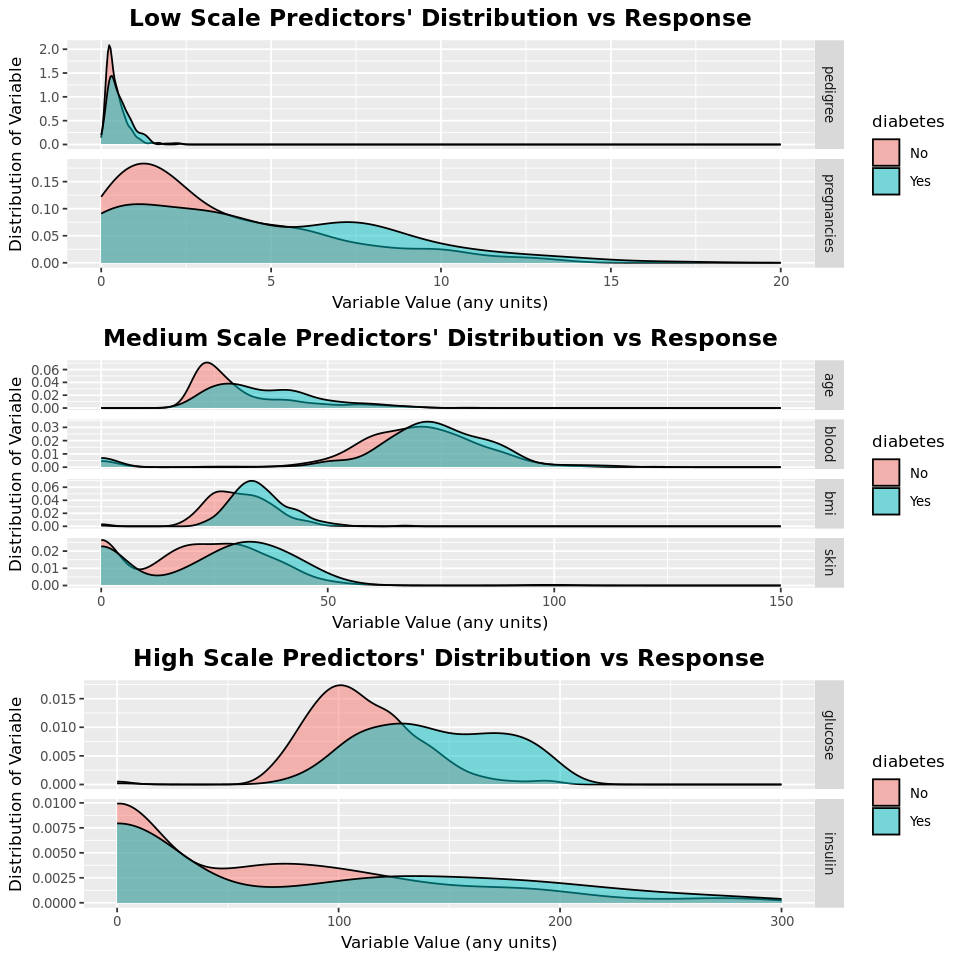

In [72]:
options(repr.plot.width = 8, repr.plot.height = 8)

diabetes_training_long <- melt(diabetes_training) |>
  mutate(variable = case_when(
    variable == "blood_pressure" ~ "blood",
    variable == "skin_thickness" ~ "skin",
    variable == "diabetes_pedigree_function" ~ "pedigree",
    TRUE ~ variable
  ))

low_scale <- c("pedigree", "pregnancies")
medium_scale <- c("age", "blood", "bmi", "skin")
high_scale <- c("glucose", "insulin")

relevance_low_scale <- diabetes_training_long |> filter(variable %in% low_scale)
relevance_medium_scale <- diabetes_training_long |> filter(variable %in% medium_scale)
relevance_high_scale <- diabetes_training_long |> filter(variable %in% high_scale)

relevance_plot_builder <- function(dataframe, xlim_top, label) {
    return (ggplot(dataframe, aes(x = value, fill = diabetes)) +
                geom_density(alpha = 0.5) +
                facet_grid(variable ~ ., scales = "free_y") +
                xlim(0, xlim_top) +
                labs(x = "Variable Value (any units)",
                     y = "Distribution of Variable",
                     title = label) +
                theme(text = element_text(size = 10, family="Verdana"),
                     plot.title = element_text(hjust = 0.5, face = "bold", size = 14)))
}

relevance_plot_low_scale <- relevance_plot_builder(relevance_low_scale,
                                                   20,
                                                  "Low Scale Predictors' Distribution vs Response")
relevance_plot_medium_scale <- relevance_plot_builder(relevance_medium_scale,
                                                      150,
                                                     "Medium Scale Predictors' Distribution vs Response")
relevance_plot_high_scale <- relevance_plot_builder(relevance_high_scale,
                                                    300,
                                                   "High Scale Predictors' Distribution vs Response")

relevance_plot <- grid.arrange(relevance_plot_low_scale, relevance_plot_medium_scale, relevance_plot_high_scale, nrow = 3)

relevance_plot

From this, we can see that the four predictor variables that are somewhat relevant to the response variable are **glucose, insulin, pregnancies, and age**.

In [ ]:
# TODO: USE GGCORR

## Discussion

## References

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.